In [1]:
import requests
import pandas as pd
import os
import json
from tqdm import tqdm
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt

api_token = os.environ.get('EODHD_API_TOKEN')


In [3]:
INDEX_NAME = 'GSPC.INDX'
url = f'https://eodhd.com/api/mp/unicornbay/spglobal/comp/{INDEX_NAME}'
query = {'api_token': api_token, "fmt": "json"}
data = requests.get(url, params=query)

if data.status_code != 200:
    print(f"Error: {data.status_code}")
    print(data.text)

data = data.json()
df_sp500 = pd.DataFrame(data['Components']).T.reset_index()

df_sp500 = df_sp500.sort_values('Weight', ascending=False)
df_sp500['CumWeight'] = df_sp500['Weight'].cumsum() / df_sp500['Weight'].sum()
df_sp500['CompanySize'] = pd.cut(df_sp500['CumWeight'], bins=[0.0, 0.40, 0.6, 0.8, 0.95, 1.0], labels=['Ultra', 'Mega', 'Large', 'Mid', 'Small'],
                           include_lowest=True)
df_sp500

,index,Code,Exchange,Name,Sector,Industry,Weight,CumWeight,CompanySize
201,201,NVDA,US,NVIDIA Corporation,Technology,Semiconductors,0.0785,0.078469,Ultra
164,164,AAPL,US,Apple Inc,Technology,Consumer Electronics,0.0673,0.145742,Ultra
247,247,MSFT,US,Microsoft Corporation,Technology,Software - Infrastructure,0.0672,0.212915,Ultra
219,219,AMZN,US,Amazon.com Inc,Consumer Cyclical,Internet Retail,0.0376,0.2505,Ultra
29,29,AVGO,US,Broadcom Inc,Technology,Semiconductors,0.0288,0.279288,Ultra
...,...,...,...,...,...,...,...,...,...
342,342,DVA,US,DaVita HealthCare Partners Inc,Healthcare,Medical Care Facilities,0.0001,0.9996,Small
353,353,APA,US,APA Corporation,Energy,Oil & Gas E&P,0.0001,0.9997,Small
362,362,BEN,US,Franklin Resources Inc,Financial Services,Asset Management,0.0001,0.9998,Small
387,387,MGM,US,MGM Resorts International,Consumer Cyclical,Resorts & Casinos,0.0001,0.9999,Small


In [4]:
insider_url = 'https://eodhd.com/api/insider-transactions'
insider_rows = []
tickers = df_sp500['Code'].tolist()

for ticker in tqdm(tickers, total=len(tickers), desc="Fetching insiders", dynamic_ncols=True, leave=True):
    ticker = f"{ticker}.US"
    resp = requests.get(insider_url, params={'api_token': api_token, 'fmt': 'json', 'code': ticker}, timeout=30)
    items = resp.json() or []
    insider_rows = insider_rows + items

df_insiders = pd.DataFrame(insider_rows)

if 'CompanySize' not in df_insiders.columns:
    df_insiders = df_insiders.merge(
        df_sp500[['Code', 'CompanySize']].rename(columns={'Code': 'code'}),
        on='code',
        how='left'
    )

df_insiders

Fetching insiders: 100%|██████████| 503/503 [00:00<00:00, 643.01it/s]


,code,exchange,date,reportDate,ownerCik,ownerName,ownerRelationship,ownerTitle,transactionDate,transactionCode,transactionAmount,transactionPrice,transactionAcquiredDisposed,postTransactionAmount,link,CompanySize
0,NVDA,US,2025-10-20,2025-10-22,None,Jen Hsun Huang,None,CEO,2025-10-20,S,75000.0,183.38,D,None,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra
1,NVDA,US,2025-10-17,2025-10-21,None,Jen Hsun Huang,None,CEO,2025-10-17,S,75000.0,182.31,D,None,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra
2,NVDA,US,2025-10-15,2025-10-17,None,Jen Hsun Huang,None,CEO,2025-10-15,S,75000.0,181.01,D,None,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra
3,NVDA,US,2025-10-13,2025-10-15,None,Jen Hsun Huang,None,CEO,2025-10-13,S,75000.0,188.25,D,None,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra
4,NVDA,US,2025-10-10,2025-10-15,None,Jen Hsun Huang,None,CEO,2025-10-10,S,75000.0,190.20,D,None,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10648,LKQ,US,2025-04-01,2025-04-03,None,Dominick P Zarcone,None,Director,2025-04-01,S,15000.0,42.15,D,None,http://www.sec.gov/Archives/edgar/data/1065696...,Small
10649,LKQ,US,2025-03-03,2025-03-05,None,Dominick P Zarcone,None,Director,2025-03-03,S,15000.0,42.32,D,None,http://www.sec.gov/Archives/edgar/data/1065696...,Small
10650,LKQ,US,2025-02-20,2025-02-24,None,Dominick P Zarcone,None,Director,2025-02-20,S,10000.0,41.66,D,None,http://www.sec.gov/Archives/edgar/data/1065696...,Small
10651,LKQ,US,2025-02-03,2025-02-05,None,Dominick P Zarcone,None,Director,2025-02-03,S,5000.0,36.14,D,None,http://www.sec.gov/Archives/edgar/data/1065696...,Small


In [6]:
df_ie = df_insiders[['code', 'exchange']].dropna()
symbols = (df_ie['code'].astype(str).str.strip() + '.' + df_ie['exchange'].astype(str).str.strip()).unique().tolist()
len(symbols)

base_url = 'https://eodhd.com/api/eod/'
from_date = '2020-11-01'# (date.today() - timedelta(days=(5 * 365)-1)).isoformat()

prices_by_symbol: dict[str, pd.DataFrame] = {}

for sym in tqdm(symbols, desc="Fetching 5y daily prices", dynamic_ncols=True):
    r = requests.get(
        f"{base_url}{sym}",
        params={'api_token': api_token, 'fmt': 'json', 'from': from_date},
        timeout=30
    )
    data = r.json() or []
    df = pd.DataFrame(data)
    # Normalize and sort
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
    prices_by_symbol[sym] = df

Fetching 5y daily prices: 100%|██████████| 498/498 [00:03<00:00, 142.87it/s]


In [7]:
def get_price_at(symbol: str, ref_date, delta: timedelta):
    if symbol not in prices_by_symbol:
        return None

    df = prices_by_symbol.get(symbol)

    # ensure datetime dtype
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    ref_dt = pd.to_datetime(ref_date)

    target_dt = ref_dt + delta

    # exact match first
    row = df.loc[df['date'] == target_dt]
    if not row.empty:
        return row.iloc[0].get('close', None)
    # otherwise, get the latest available date <= target_dt
    hist = df.loc[df['date'] <= target_dt]
    if hist.empty:
        return None
    return hist.iloc[-1].get('close', None)

In [8]:
df_insiders['price_on_report_date'] = np.nan
df_insiders['3D_price'] = np.nan
df_insiders['7D_price'] = np.nan
df_insiders['1M_price'] = np.nan

for idx, row in df_insiders.iterrows():
    df_insiders.at[idx, 'price_on_report_date'] = get_price_at(f"{row.get('code')}.US", row.get('reportDate'), timedelta(days=0))
    df_insiders.at[idx, '3D_price'] = get_price_at(f"{row.get('code')}.US", row.get('date'), timedelta(days=3))
    df_insiders.at[idx, '7D_price'] = get_price_at(f"{row.get('code')}.US", row.get('date'), timedelta(days=7))
    df_insiders.at[idx, '1M_price'] = get_price_at(f"{row.get('code')}.US", row.get('date'), timedelta(days=30))

df_insiders['3D_Return'] = ((df_insiders['3D_price'] - df_insiders['transactionPrice']) / df_insiders['transactionPrice'])*100
df_insiders.loc[df_insiders['transactionCode'].astype(str).str.upper().str.strip() == 'S', '3D_Return'] *= -1

df_insiders['7D_Return'] = ((df_insiders['7D_price'] - df_insiders['transactionPrice']) / df_insiders['transactionPrice'])*100
df_insiders.loc[df_insiders['transactionCode'].astype(str).str.upper().str.strip() == 'S', '7D_Return'] *= -1

df_insiders['1M_Return'] = ((df_insiders['1M_price'] - df_insiders['transactionPrice']) / df_insiders['transactionPrice'])*100
df_insiders.loc[df_insiders['transactionCode'].astype(str).str.upper().str.strip() == 'S', '1M_Return'] *= -1

df_insiders['1M_Return_from_reporting_date'] = ((df_insiders['1M_price'] - df_insiders['price_on_report_date']) / df_insiders['price_on_report_date'])*100
df_insiders.loc[df_insiders['transactionCode'].astype(str).str.upper().str.strip() == 'S', '1M_Return_from_reporting_date'] *= -1
df_insiders

,code,exchange,date,reportDate,ownerCik,ownerName,ownerRelationship,ownerTitle,transactionDate,transactionCode,...,link,CompanySize,price_on_report_date,3D_price,7D_price,1M_price,3D_Return,7D_Return,1M_Return,1M_Return_from_reporting_date
0,NVDA,US,2025-10-20,2025-10-22,None,Jen Hsun Huang,None,CEO,2025-10-20,S,...,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra,180.28,182.16,191.49,207.04,0.665285,-4.422511,-12.902170,-14.843577
1,NVDA,US,2025-10-17,2025-10-21,None,Jen Hsun Huang,None,CEO,2025-10-17,S,...,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra,181.16,182.64,186.26,207.04,-0.181010,-2.166639,-13.564807,-14.285714
2,NVDA,US,2025-10-15,2025-10-17,None,Jen Hsun Huang,None,CEO,2025-10-15,S,...,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra,183.22,183.22,180.28,207.04,-1.220927,0.403293,-14.380421,-13.000764
3,NVDA,US,2025-10-13,2025-10-15,None,Jen Hsun Huang,None,CEO,2025-10-13,S,...,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra,179.83,181.81,182.64,207.04,3.420983,2.980080,-9.981408,-15.130957
4,NVDA,US,2025-10-10,2025-10-15,None,Jen Hsun Huang,None,CEO,2025-10-10,S,...,http://www.sec.gov/Archives/edgar/data/1045810...,Ultra,179.83,188.32,183.22,207.04,0.988433,3.669821,-8.853838,-15.130957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10648,LKQ,US,2025-04-01,2025-04-03,None,Dominick P Zarcone,None,Director,2025-04-01,S,...,http://www.sec.gov/Archives/edgar/data/1065696...,Small,42.18,41.29,38.54,38.13,2.040332,8.564650,9.537367,9.601707
10649,LKQ,US,2025-03-03,2025-03-05,None,Dominick P Zarcone,None,Director,2025-03-03,S,...,http://www.sec.gov/Archives/edgar/data/1065696...,Small,42.05,42.75,44.05,43.38,-1.016068,-4.087902,-2.504726,-3.162901
10650,LKQ,US,2025-02-20,2025-02-24,None,Dominick P Zarcone,None,Director,2025-02-20,S,...,http://www.sec.gov/Archives/edgar/data/1065696...,Small,41.25,40.49,41.87,40.40,2.808449,-0.504081,3.024484,2.060606
10651,LKQ,US,2025-02-03,2025-02-05,None,Dominick P Zarcone,None,Director,2025-02-03,S,...,http://www.sec.gov/Archives/edgar/data/1065696...,Small,36.78,37.37,37.35,42.05,-3.403431,-3.348091,-16.353071,-14.328439


In [9]:
df_insiders['ownerTitleAgg'] = df_insiders['ownerTitle']

df_insiders.loc[
    df_insiders['ownerTitleAgg'].str.startswith('U.S. Congress Member', na=False), 'ownerTitleAgg'] = 'U.S. Congress Member'
df_insiders.loc[
    df_insiders['ownerTitleAgg'].isin(['CEO', 'CAO', 'CFO', 'COO', 'CIO', 'CRO', 'CMO', 'CTO']), 'ownerTitleAgg'] = 'C-Level'
df_insiders.loc[
    df_insiders['ownerTitleAgg'].isin(['SVP', 'EVP', 'VP', 'Treasurer', 'Director', 'General Counsel']), 'ownerTitleAgg'] = 'Senior Management'
df_insiders.loc[
    df_insiders['ownerTitleAgg'].isin(['Vice Chairman', 'Chairman', 'President']), 'ownerTitleAgg'] = 'Board'
df_insiders.loc[
    df_insiders['ownerTitleAgg'].isin(['Insider', 'insider']), 'ownerTitleAgg'] = 'Insider'

In [10]:
if 'ownerTitleAgg' in df_insiders.columns:
    df_insiders = df_insiders[df_insiders['ownerTitleAgg'] != 'U.S. Congress Member']

In [11]:
if '1M_Return' in df_insiders.columns:
    df_insiders['1M_Return'] = pd.to_numeric(df_insiders['1M_Return'], errors='coerce')
    df_insiders = df_insiders[df_insiders['1M_Return'].abs() <= 50]

In [12]:
def stats(series: pd.Series):
    s = pd.to_numeric(series, errors='coerce').dropna()
    wins = int((s > 0).sum())
    losses = int((s <= 0).sum())
    avg = s.mean()
    return wins, losses, avg

df_insiders_copy = df_insiders.copy()

summary = []
for period, col in [('3D', '3D_Return'), ('7D', '7D_Return'), ('1M', '1M_Return')]:
    # Overall
    wins, losses, avg = stats(df_insiders_copy[col])
    summary.append(
        {'Period': period, 'transactionCode': 'All', 'Wins': wins, 'Losses': losses, 'AverageReturn(%)': avg})
    # Purchases (P)
    mask_p = df_insiders_copy['transactionCode'].astype(str).str.upper().str.strip() == 'P'
    wins_p, losses_p, avg_p = stats(df_insiders_copy.loc[mask_p, col])
    summary.append(
        {'Period': period, 'transactionCode': 'P', 'Wins': wins_p, 'Losses': losses_p, 'AverageReturn(%)': avg_p})
    # Sales (S)
    mask_s = df_insiders_copy['transactionCode'].astype(str).str.upper().str.strip() == 'S'
    wins_s, losses_s, avg_s = stats(df_insiders_copy.loc[mask_s, col])
    summary.append(
        {'Period': period, 'transactionCode': 'S', 'Wins': wins_s, 'Losses': losses_s, 'AverageReturn(%)': avg_s})

df_summary = pd.DataFrame(summary)
df_summary

,Period,transactionCode,Wins,Losses,AverageReturn(%)
0,3D,All,2754,2919,-1.029811
1,3D,P,215,204,0.321803
2,3D,S,2539,2715,-1.137601
3,7D,All,2717,2956,-1.203980
4,7D,P,233,186,0.768514
5,7D,S,2484,2770,-1.361283
6,1M,All,2666,3007,-1.141693
7,1M,P,211,208,0.255423
8,1M,S,2455,2799,-1.253111


In [25]:
df_insiders_copy = df_insiders.copy()
df_insiders_copy = df_insiders_copy[df_insiders_copy['transactionCode'].astype(str).str.upper().str.strip() == 'P']

# Compute average returns per code
df_avg_by_ownerTitle = (
    df_insiders_copy
    .copy()
    .assign(
        Return_3D=pd.to_numeric(df_insiders_copy['3D_Return'], errors='coerce'),
        Return_7D=pd.to_numeric(df_insiders_copy['7D_Return'], errors='coerce'),
        Return_1M=pd.to_numeric(df_insiders_copy['1M_Return'], errors='coerce')
    )
    .groupby('ownerTitleAgg', as_index=False)
    .agg(
        Trades=('ownerTitle', 'count'),
        Avg_3D_Return=('Return_3D', 'mean'),
        Avg_7D_Return=('Return_7D', 'mean'),
        Avg_1M_Return=('Return_1M', 'mean')
    )
    .sort_values('Avg_1M_Return', ascending=False)
)

df_avg_by_ownerTitle

,ownerTitleAgg,Trades,Avg_3D_Return,Avg_7D_Return,Avg_1M_Return
2,Insider,6,1.422847,5.595959,5.581021
3,Major Shareholder,49,1.237414,2.436621,4.251015
1,C-Level,64,0.366045,1.337127,1.266995
4,Senior Management,299,0.153601,0.283183,-0.716043
0,Board,1,-3.688341,-1.210762,-1.754484


In [14]:
df_insiders_copy = df_insiders.copy()
df_insiders_copy = df_insiders_copy[df_insiders_copy['transactionCode'].astype(str).str.upper().str.strip() == 'P']

df_avg_by_company_size = (
    df_insiders_copy
    .copy()
    .assign(
        Return_3D=pd.to_numeric(df_insiders_copy['3D_Return'], errors='coerce'),
        Return_7D=pd.to_numeric(df_insiders_copy['7D_Return'], errors='coerce'),
        Return_1M=pd.to_numeric(df_insiders_copy['1M_Return'], errors='coerce')
    )
    .groupby('CompanySize', as_index=False)
    .agg(
        Trades=('CompanySize', 'count'),
        Avg_3D_Return=('Return_3D', 'mean'),
        Avg_7D_Return=('Return_7D', 'mean'),
        Avg_1M_Return=('Return_1M', 'mean')
    )
    .sort_values('Avg_1M_Return', ascending=False)
)

df_avg_by_company_size

,CompanySize,Trades,Avg_3D_Return,Avg_7D_Return,Avg_1M_Return
1,Mega,26,1.762661,2.829134,6.299969
0,Ultra,4,5.138153,4.096491,5.900320
2,Large,42,-0.452141,0.724366,1.752583
3,Mid,105,0.514011,0.240352,0.471899
4,Small,242,0.138316,0.728940,-0.841058


In [15]:
df_insiders_copy = df_insiders.copy()
df_insiders_copy = df_insiders_copy[df_insiders_copy['transactionCode'].astype(str).str.upper().str.strip() == 'P']

# Compute average returns per code
df_avg_by_code = (
    df_insiders_copy
    .copy()
    .assign(
        Return_3D=pd.to_numeric(df_insiders_copy['3D_Return'], errors='coerce'),
        Return_7D=pd.to_numeric(df_insiders_copy['7D_Return'], errors='coerce'),
        Return_1M=pd.to_numeric(df_insiders_copy['1M_Return'], errors='coerce')
    )
    .groupby('code', as_index=False)
    .agg(
        Trades=('code', 'count'),
        Avg_3D_Return=('Return_3D', 'mean'),
        Avg_7D_Return=('Return_7D', 'mean'),
        Avg_1M_Return=('Return_1M', 'mean')
    )
    .sort_values('Avg_1M_Return', ascending=False)
)

df_avg_by_code[df_avg_by_code['Trades'] > 2]


,code,Trades,Avg_3D_Return,Avg_7D_Return,Avg_1M_Return
133,WBD,3,3.192685,2.114866,18.198755
82,LLY,5,7.429534,9.741016,17.180501
48,EL,4,0.167963,7.648767,15.602626
100,OXY,3,2.863292,4.131146,9.315811
107,PSX,4,-1.448003,-0.945571,8.208468
125,UNH,6,1.629625,1.492608,5.412543
33,COP,3,-0.891736,-0.764974,5.166252
20,BMY,3,0.520727,2.373317,4.797448
75,KEY,3,4.335822,4.410332,4.494104
31,CNC,7,-0.916529,1.130053,4.266675


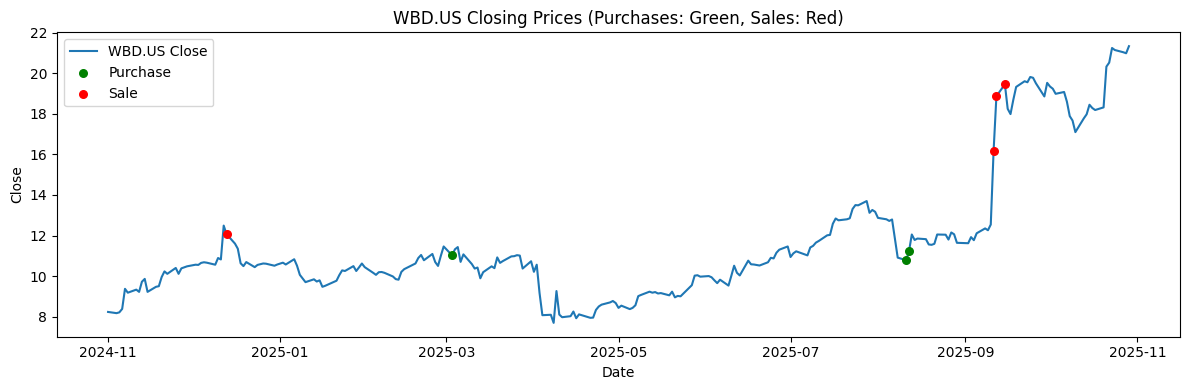

In [34]:

# Ensure required data exists
symbol = 'WBD.US'
if symbol not in prices_by_symbol or prices_by_symbol[symbol].empty:
    raise ValueError(f"{symbol}.US not found in prices_by_symbol or has no data.")

# Get last year's price data
end_dt = pd.to_datetime(date.today())
start_dt = end_dt - timedelta(days=365)
df_plot = prices_by_symbol[symbol].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot_all = df_plot[(df_plot['date'] >= start_dt) & (df_plot['date'] <= end_dt)][['date', 'close']].reset_index(drop=True)

df_events_all = df_insiders.copy()
base_symbol = str(symbol).split('.', 1)[0].upper().strip()
df_events_all = df_events_all[df_events_all['code'] == base_symbol]
df_events_all['date'] = pd.to_datetime(df_events_all['date'], errors='coerce')
df_events_all['reportDate'] = pd.to_datetime(df_events_all['reportDate'], errors='coerce')
df_events_all['event_date'] = df_events_all['date'].fillna(df_events_all['reportDate'])
df_events_all = df_events_all.dropna(subset=['event_date'])

# Split purchases and sales
df_p = df_events_all[df_events_all['transactionCode'].astype(str).str.upper().str.strip() == 'P']
df_s = df_events_all[df_events_all['transactionCode'].astype(str).str.upper().str.strip() == 'S']

# Match event dates to available trading dates (use last available close on/before event)
df_prices_for_merge = df_plot[['date', 'close']].sort_values('date').dropna()


def align_events(df_events):
    if df_events.empty:
        return pd.DataFrame(columns=['date', 'close'])
    df_ev = df_events[['event_date']].sort_values('event_date')
    out = pd.merge_asof(
        df_ev.rename(columns={'event_date': 'date'}),
        df_prices_for_merge,
        on='date',
        direction='backward'
    )
    return out


matched_p = align_events(df_p)
matched_s = align_events(df_s)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(df_plot_all['date'], df_plot_all['close'], label=f'{symbol} Close', color='#1f77b4')
if not matched_p.empty:
    plt.scatter(matched_p['date'], matched_p['close'], color='green', s=30, zorder=3, label='Purchase')
if not matched_s.empty:
    plt.scatter(matched_s['date'], matched_s['close'], color='red', s=30, zorder=3, label='Sale')

plt.title(f'{symbol} Closing Prices (Purchases: Green, Sales: Red)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.tight_layout()
plt.show()
